# Classification of the breed of chickens using Data Augmentation and Transfer Learning
In this notebook a CNN is created to distinguish between nine different chickens (of different breeds).
First a baseline model is built and then enhanced with Data Augmentation and Transfer Learning.

## Imports
All dependencies needed for the model are loaded here.

In [1]:
%matplotlib inline
import os
import shutil
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Concatenate, AvgPool2D, Input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from tensorflow.keras import Model
from tensorflow.keras import layers

## Load the training and validation images
The images are in a folder `Chickens` where each of the nine chickens has its own subdirectory.
For further use the images are copied to `/tmp` where each model will load them from.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Google Colab
# DATASET_PATH = '/tmp/chickens'
# BASE_PATH = '/content/drive/MyDrive/Chickens'

# Hannes
#BASE_PATH = '/Users/hannes/Google Drive/My Drive/Chickens'
#DATASET_PATH = '/tmp/Chickens'

# Paul
BASE_PATH = '/Users/pkeller/Pictures/chickens'
DATASET_PATH = '/Users/pkeller/Pictures/AIchickens'

blacklisted_files = ['.DS_Store', 'Icon\r']
# Allows to use only a subset of the available classes for training
# breeds = ['Amaretto', 'Aria', 'Chick Pea', 'Espresso', 'Lucifer', 'Oreo', 'Popcorn', 'Pumpkin', 'Whiskey']
breeds = ['Aria', 'Lucifer', 'Popcorn']

# Cleanup existing files to always start with a clean slate
if os.path.exists(DATASET_PATH):
    shutil.rmtree(DATASET_PATH)
    print('Removed existing files')

os.mkdir(DATASET_PATH)

num_copied_files = 0

for breed in breeds:
    breed_source_path = os.path.join(BASE_PATH, breed)
    breed_target_path = os.path.join(DATASET_PATH, breed)

    if os.path.isdir(breed_source_path):
        os.mkdir(breed_target_path)

        for image in os.listdir(breed_source_path):
            sourcePath = os.path.join(breed_source_path, image)
            targetPath = os.path.join(breed_target_path, image)
            shutil.copy(sourcePath, targetPath)
            num_copied_files += 1

# remove .DS_store and other wrong files
for breed in breeds:
    if breed in blacklisted_files:
        path_to_file = os.path.join(DATASET_PATH, breed)
        os.remove(path_to_file)
        print(path_to_file + ' removed')
        num_copied_files -= 1
        continue

    breed_directory = os.path.join(DATASET_PATH, breed)

    if os.path.isdir(breed_directory):
        for filename in os.listdir(breed_directory):
            if filename in blacklisted_files:
                path_to_file = os.path.join(breed_directory, filename)
                os.remove(path_to_file)
                print(path_to_file + ' removed')
                num_copied_files -= 1

print(f"Copied {num_copied_files} files")
print(f"We have {len(breeds)} chickens")

Removed existing files
Copied 450 files
We have 3 chickens


## Explore dataset
Next we explore the dataset a bit by showing a random collection of each chicken.

There are 150 images of Aria.


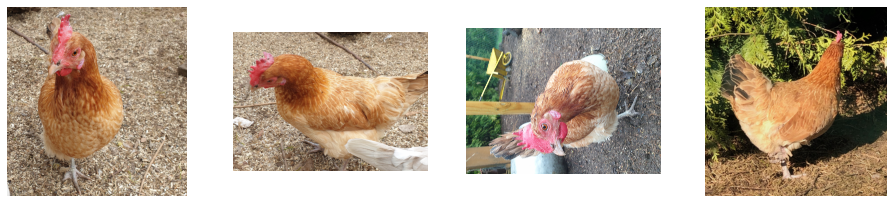

There are 150 images of Lucifer.


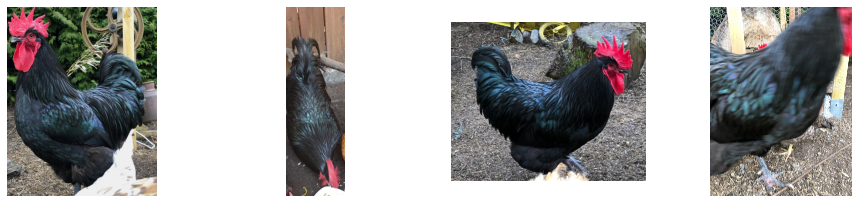

There are 150 images of Popcorn.


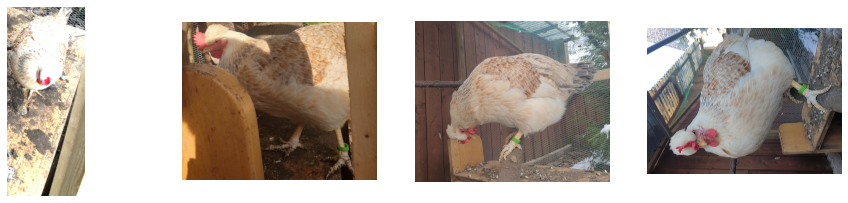

In [4]:
for breed in breeds:
  breed_directory = os.path.join(DATASET_PATH, breed)
  breed_dir_list = os.listdir(breed_directory)

  print(f"There are {len(breed_dir_list)} images of {breed}.")
  
  # show images of dataset
  rows = 4
  cols = 4
  pic_index = 0
  fig = plt.gcf()
  fig.set_size_inches(cols * 4, rows * 4)
  pic_index+=4
  next_pic = [os.path.join(breed_directory, file_name)
              for file_name in breed_dir_list[pic_index - 4:pic_index]
              ]
  for i, img_path in enumerate(next_pic):
    #subplot
    sp = plt.subplot(rows, cols, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

## Global parameters
Here some global parameters are set to be consistent in each model that is built.

In [5]:
BATCH_SIZE = 32
EPOCHS = 100
SEED = 42
IMG_SIZE = int(244 / 10)
SPLIT = 0.3 # 70% training images and 30% validation images

#### Tensorboard settings

In [6]:
import time
# log directory "logs" 
root_logdir = os.path.join(os.curdir, "logs")

# function that prepends the time of a run
def get_run_logdir(name: str = ""):
  run_id = time.strftime("%m_%d-%H_%M")
  run_name = run_id + name
  return os.path.join(root_logdir, run_name)

## First Model
As a start we build a very simple model without any Data Augmentation or Transfer Learning.

### Get the training and validation data

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT)

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='training',
                                             seed=SEED)
validation_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='validation',
                                             seed=SEED)

Found 315 images belonging to 3 classes.
Found 135 images belonging to 3 classes.


### Create the model

In [8]:
def create_model():
    # model = Sequential([
    #     Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    #     Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    #     Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    #     Dropout(0.3),
    #     Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    #     MaxPool2D((2, 2)),
    #     Conv2D(32, (3, 3), activation='relu'),
    #     MaxPool2D((2, 2)),
    #     Flatten(),
    #     Dense(64, activation='relu'),
    #     Dropout(0.5),
    #     Dense(9, activation='softmax'),
    # ])

    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    input_layer = Conv2D(256, (1, 1), padding='same')(input_tensor)

    blocks = []

    block_1_pool = AvgPool2D((1, 1), padding='same')(input_layer)
    block_1_conv = Conv2D(256, (1, 1), padding='same', activation='relu')(block_1_pool)
    blocks.append(block_1_conv)

    block_2_conv = Conv2D(256, (1, 1), padding='same', activation='relu')(input_layer)
    blocks.append(block_2_conv)

    block_3_conv = Conv2D(384, (1, 1), padding='same', activation='relu')(input_layer)
    block_3_concat_conv_1 = Conv2D(256, (1, 3), padding='same', activation='relu')(block_3_conv)
    block_3_concat_conv_2 = Conv2D(256, (3, 1), padding='same', activation='relu')(block_3_conv)
    block_3_concat = Concatenate(axis=3)([block_3_concat_conv_1, block_3_concat_conv_2])
    blocks.append(block_3_concat)

    block_4_conv_1 = Conv2D(384, (1, 1), padding='same', activation='relu')(input_layer)
    block_4_conv_2 = Conv2D(448, (1, 3), padding='same', activation='relu')(block_4_conv_1)
    block_4_conv_3 = Conv2D(512, (3, 1), padding='same', activation='relu')(block_4_conv_2)
    block_4_concat_conv_1 = Conv2D(256, (1, 3), padding='same', activation='relu')(block_4_conv_3)
    block_4_concat_conv_2 = Conv2D(256, (3, 1), padding='same', activation='relu')(block_4_conv_3)
    block_4_concat = Concatenate(axis=3)([block_4_concat_conv_1, block_4_concat_conv_2])
    blocks.append(block_4_concat)

    full_concat = Concatenate(axis=3)(blocks)
    inception_v4_block = Model(input_tensor, full_concat)

    model = Sequential()
    model.add(inception_v4_block)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(len(breeds), activation='softmax'))

    model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

model = create_model()

model.summary()

2022-06-27 08:33:06.989349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-27 08:33:06.989570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 24, 24, 1536)      2912448   
                                                                 
 flatten (Flatten)           (None, 884736)            0         
                                                                 
 dense (Dense)               (None, 256)               226492672 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 229,405,891
Trainable params: 229,405,891
Non-trainable params: 0
__________________________

In [9]:
# Tensorboard
tensorboard = keras.callbacks.TensorBoard(get_run_logdir("#1.Model"), 
                                             histogram_freq=1,)
          
history = model.fit(train_generator,
                    epochs=int(EPOCHS),
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[tensorboard])

Epoch 1/100


2022-06-27 08:33:09.353749: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-27 08:33:09.965849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 4.2582 - accuracy: 0.3841

2022-06-27 08:33:24.845414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 88s 9s/step - loss: 4.2582 - accuracy: 0.3841 - val_loss: 1.3360 - val_accuracy: 0.5926
Epoch 2/100
10/10 [==============================] - 86s 9s/step - loss: 0.8287 - accuracy: 0.6730 - val_loss: 1.2605 - val_accuracy: 0.6296
Epoch 3/100
10/10 [==============================] - 85s 9s/step - loss: 0.7311 - accuracy: 0.7079 - val_loss: 0.3516 - val_accuracy: 0.8963
Epoch 4/100
10/10 [==============================] - 87s 9s/step - loss: 0.2942 - accuracy: 0.8762 - val_loss: 0.3680 - val_accuracy: 0.8667
Epoch 5/100
10/10 [==============================] - 87s 9s/step - loss: 0.3474 - accuracy: 0.8508 - val_loss: 0.3458 - val_accuracy: 0.8889
Epoch 6/100
10/10 [==============================] - 86s 9s/step - loss: 0.1890 - accuracy: 0.9429 - val_loss: 0.1751 - val_accuracy: 0.9704
Epoch 7/100
10/10 [==============================] - 87s 9s/step - loss: 0.2302 - accuracy: 0.9238 - val_loss: 0.2216 - val_accuracy: 0.9259
Epoch 8/100
10/10 [======

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x41bb60350>
    label = <none> 
    device = <AGXG13XDevice: 0x16d9e2800>
        name = Apple M1 Max 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10f066600>
        label = <none> 
        device = <AGXG13XDevice: 0x16d9e2800>
            name = Apple M1 Max 
    retainedReferences = 1


10/10 [==============================] - 85s 9s/step - loss: 3.3048e-05 - accuracy: 1.0000 - val_loss: 0.1796 - val_accuracy: 0.9852
Epoch 52/100
10/10 [==============================] - 87s 9s/step - loss: 2.0697e-05 - accuracy: 1.0000 - val_loss: 0.1780 - val_accuracy: 0.9852
Epoch 53/100


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x319022110>
    label = <none> 
    device = <AGXG13XDevice: 0x16d9e2800>
        name = Apple M1 Max 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10f066600>
        label = <none> 
        device = <AGXG13XDevice: 0x16d9e2800>
            name = Apple M1 Max 
    retainedReferences = 1


10/10 [==============================] - 87s 9s/step - loss: 0.4421 - accuracy: 0.9524 - val_loss: 0.2055 - val_accuracy: 0.9556
Epoch 54/100
10/10 [==============================] - 86s 9s/step - loss: 0.0067 - accuracy: 0.9968 - val_loss: 0.2428 - val_accuracy: 0.9481
Epoch 55/100
10/10 [==============================] - 86s 9s/step - loss: 7.7954e-04 - accuracy: 1.0000 - val_loss: 0.1933 - val_accuracy: 0.9630
Epoch 56/100
10/10 [==============================] - 87s 9s/step - loss: 1.4080e-04 - accuracy: 1.0000 - val_loss: 0.1893 - val_accuracy: 0.9704
Epoch 57/100
10/10 [==============================] - 87s 9s/step - loss: 4.1158e-05 - accuracy: 1.0000 - val_loss: 0.1891 - val_accuracy: 0.9778
Epoch 58/100
10/10 [==============================] - ETA: 0s - loss: 6.2186e-05 - accuracy: 1.0000

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x522df69f0>
    label = <none> 
    device = <AGXG13XDevice: 0x16d9e2800>
        name = Apple M1 Max 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10f066600>
        label = <none> 
        device = <AGXG13XDevice: 0x16d9e2800>
            name = Apple M1 Max 
    retainedReferences = 1


10/10 [==============================] - 86s 9s/step - loss: 6.2186e-05 - accuracy: 1.0000 - val_loss: 0.4258 - val_accuracy: 0.8444
Epoch 59/100
10/10 [==============================] - 87s 9s/step - loss: 2.9941e-05 - accuracy: 1.0000 - val_loss: 0.1900 - val_accuracy: 0.9778
Epoch 60/100
10/10 [==============================] - 86s 9s/step - loss: 2.5684e-05 - accuracy: 1.0000 - val_loss: 0.1931 - val_accuracy: 0.9852
Epoch 61/100
10/10 [==============================] - 87s 9s/step - loss: 1.7073e-05 - accuracy: 1.0000 - val_loss: 0.1945 - val_accuracy: 0.9852
Epoch 62/100
10/10 [==============================] - 86s 9s/step - loss: 6.2849e-05 - accuracy: 1.0000 - val_loss: 0.3154 - val_accuracy: 0.9185
Epoch 63/100
10/10 [==============================] - 87s 9s/step - loss: 0.0093 - accuracy: 0.9968 - val_loss: 0.2991 - val_accuracy: 0.9407
Epoch 64/100
10/10 [==============================] - 86s 9s/step - loss: 5.7884e-05 - accuracy: 1.0000 - val_loss: 0.2794 - val_accuracy: 0.

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x41bb743b0>
    label = <none> 
    device = <AGXG13XDevice: 0x16d9e2800>
        name = Apple M1 Max 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10f066600>
        label = <none> 
        device = <AGXG13XDevice: 0x16d9e2800>
            name = Apple M1 Max 
    retainedReferences = 1


10/10 [==============================] - 87s 9s/step - loss: 2.8042e-07 - accuracy: 1.0000 - val_loss: 0.4862 - val_accuracy: 0.8074
Epoch 78/100
10/10 [==============================] - 87s 9s/step - loss: 4.5591e-07 - accuracy: 1.0000 - val_loss: 0.2614 - val_accuracy: 0.9704
Epoch 79/100
10/10 [==============================] - 86s 9s/step - loss: 3.9374e-07 - accuracy: 1.0000 - val_loss: 0.2647 - val_accuracy: 0.9778
Epoch 80/100
10/10 [==============================] - 86s 9s/step - loss: 1.8572e-07 - accuracy: 1.0000 - val_loss: 0.2624 - val_accuracy: 0.9778
Epoch 81/100
10/10 [==============================] - 86s 9s/step - loss: 7.8957e-08 - accuracy: 1.0000 - val_loss: 0.2631 - val_accuracy: 0.9778
Epoch 82/100
10/10 [==============================] - 87s 9s/step - loss: 2.8697e-07 - accuracy: 1.0000 - val_loss: 0.2625 - val_accuracy: 0.9778
Epoch 83/100
10/10 [==============================] - 86s 9s/step - loss: 2.4946e-07 - accuracy: 1.0000 - val_loss: 0.2755 - val_accuracy

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x41b8982f0>
    label = <none> 
    device = <AGXG13XDevice: 0x16d9e2800>
        name = Apple M1 Max 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10f066600>
        label = <none> 
        device = <AGXG13XDevice: 0x16d9e2800>
            name = Apple M1 Max 
    retainedReferences = 1


10/10 [==============================] - 85s 9s/step - loss: 1.7051e-07 - accuracy: 1.0000 - val_loss: 0.2694 - val_accuracy: 0.9852
Epoch 85/100
10/10 [==============================] - 87s 9s/step - loss: 5.2988e-08 - accuracy: 1.0000 - val_loss: 0.2721 - val_accuracy: 0.9778
Epoch 86/100
10/10 [==============================] - 87s 9s/step - loss: 5.1414e-08 - accuracy: 1.0000 - val_loss: 0.2734 - val_accuracy: 0.9852
Epoch 87/100
10/10 [==============================] - 86s 9s/step - loss: 4.7742e-08 - accuracy: 1.0000 - val_loss: 0.2734 - val_accuracy: 0.9852
Epoch 88/100


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x3d4da1ec0>
    label = <none> 
    device = <AGXG13XDevice: 0x16d9e2800>
        name = Apple M1 Max 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10f066600>
        label = <none> 
        device = <AGXG13XDevice: 0x16d9e2800>
            name = Apple M1 Max 
    retainedReferences = 1


10/10 [==============================] - 86s 9s/step - loss: 0.2052 - accuracy: 0.9651 - val_loss: 0.2009 - val_accuracy: 0.9778
Epoch 89/100
10/10 [==============================] - 86s 9s/step - loss: 5.3008e-05 - accuracy: 1.0000 - val_loss: 0.2031 - val_accuracy: 0.9778
Epoch 90/100
10/10 [==============================] - 86s 9s/step - loss: 4.0077e-05 - accuracy: 1.0000 - val_loss: 0.2083 - val_accuracy: 0.9778
Epoch 91/100
10/10 [==============================] - 85s 9s/step - loss: 2.3448e-05 - accuracy: 1.0000 - val_loss: 0.2116 - val_accuracy: 0.9778
Epoch 92/100
10/10 [==============================] - 85s 9s/step - loss: 1.3913e-05 - accuracy: 1.0000 - val_loss: 0.2142 - val_accuracy: 0.9778
Epoch 93/100
10/10 [==============================] - 86s 9s/step - loss: 1.2987e-05 - accuracy: 1.0000 - val_loss: 0.2184 - val_accuracy: 0.9778
Epoch 94/100
10/10 [==============================] - 86s 9s/step - loss: 1.7496e-05 - accuracy: 1.0000 - val_loss: 0.2228 - val_accuracy: 0.

In [10]:
def plot_training_validation_accuracy_loss(history_to_plot):
    acc = history_to_plot.history['accuracy']
    val_acc = history_to_plot.history['val_accuracy']
    loss = history_to_plot.history['loss']
    val_loss = history_to_plot.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

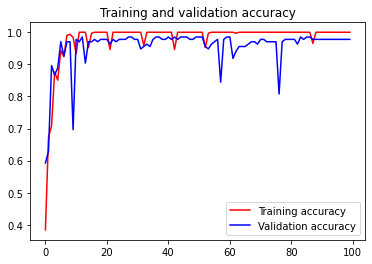

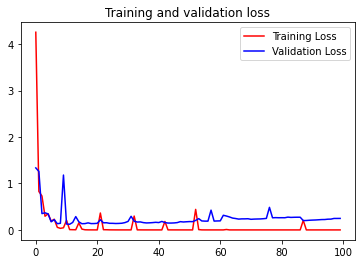

In [11]:
plot_training_validation_accuracy_loss(history)

As we can see the accuracy is not even near a good value.
In the next parts we will try some measures to gain a better accuracy.

## 1. Measure: Data Augmentation

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT,
                                            rotation_range=20,
                                            width_shift_range=0.1,                               
                                            height_shift_range=0.1,
                                            shear_range=0.1,                          
                                            zoom_range=0.1,                          
                                            horizontal_flip=True,
                                            fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            target_size=(IMG_SIZE,IMG_SIZE),
                                            subset='training',
                                            seed=SEED)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT)

validation_generator = test_datagen.flow_from_directory(DATASET_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='validation',
                                             seed=SEED)

Found 315 images belonging to 3 classes.
Found 135 images belonging to 3 classes.


In [13]:
# def create_other_model():
#     model = tf.keras.models.Sequential([
#
#     # First Block
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#
#     # Second Block
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.Conv2D(23, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#
#     # Third Block
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#
#     # Fourth Block
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.MaxPooling2D(2, 2),
#
#     # Fith Block
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.MaxPooling2D(2, 2),
#
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#
#     tf.keras.layers.MaxPooling2D(2, 2),
#     # Flatten the results to feed into a DNN
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(9, activation='softmax')
#     ])
#
#
#      # Set training parameters
#     model.compile(loss='categorical_crossentropy',
#               optimizer=RMSprop(learning_rate=1e-4),
#               metrics=['accuracy'])
#
#     return model

model = create_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 24, 24, 1536)      2912448   
                                                                 
 flatten_1 (Flatten)         (None, 884736)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               226492672 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 229,405,891
Trainable params: 229,405,891
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Tensorboard
tensorboard = keras.callbacks.TensorBoard(get_run_logdir("#2.Model"), 
                                             histogram_freq=1,)
         
history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            verbose=1,
            callbacks=[tensorboard])

Epoch 1/100


2022-06-27 10:57:01.136654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 3.5939 - accuracy: 0.3841

2022-06-27 10:57:16.253453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 89s 10s/step - loss: 3.5939 - accuracy: 0.3841 - val_loss: 1.0099 - val_accuracy: 0.3630
Epoch 2/100
10/10 [==============================] - 87s 9s/step - loss: 1.0096 - accuracy: 0.5714 - val_loss: 0.5788 - val_accuracy: 0.7185
Epoch 3/100
10/10 [==============================] - 87s 9s/step - loss: 0.7310 - accuracy: 0.6762 - val_loss: 0.3391 - val_accuracy: 0.9259
Epoch 4/100
10/10 [==============================] - 87s 9s/step - loss: 0.5027 - accuracy: 0.7968 - val_loss: 0.6025 - val_accuracy: 0.7704
Epoch 5/100
10/10 [==============================] - 87s 9s/step - loss: 0.5049 - accuracy: 0.7841 - val_loss: 0.2625 - val_accuracy: 0.8889
Epoch 6/100
10/10 [==============================] - 87s 9s/step - loss: 0.4156 - accuracy: 0.8413 - val_loss: 0.1542 - val_accuracy: 0.9778
Epoch 7/100
10/10 [==============================] - 87s 9s/step - loss: 0.3039 - accuracy: 0.8825 - val_loss: 0.3630 - val_accuracy: 0.8222
Epoch 8/100
10/10 [=====

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x30b122980>
    label = <none> 
    device = <AGXG13XDevice: 0x16d9e2800>
        name = Apple M1 Max 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10f066600>
        label = <none> 
        device = <AGXG13XDevice: 0x16d9e2800>
            name = Apple M1 Max 
    retainedReferences = 1


10/10 [==============================] - 87s 9s/step - loss: 0.0511 - accuracy: 0.9810 - val_loss: 0.2404 - val_accuracy: 0.8667
Epoch 59/100
10/10 [==============================] - 87s 9s/step - loss: 0.0752 - accuracy: 0.9714 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 60/100
10/10 [==============================] - 86s 9s/step - loss: 0.0278 - accuracy: 0.9873 - val_loss: 0.0608 - val_accuracy: 0.9704
Epoch 61/100
10/10 [==============================] - 87s 9s/step - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.0452 - val_accuracy: 0.9852
Epoch 62/100
10/10 [==============================] - 87s 9s/step - loss: 0.1017 - accuracy: 0.9683 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 63/100
10/10 [==============================] - 86s 9s/step - loss: 0.0244 - accuracy: 0.9873 - val_loss: 0.0413 - val_accuracy: 0.9852
Epoch 64/100
10/10 [==============================] - 87s 9s/step - loss: 0.0157 - accuracy: 0.9968 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 65/100
10/10 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x30b1829d0>
    label = <none> 
    device = <AGXG13XDevice: 0x16d9e2800>
        name = Apple M1 Max 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10f066600>
        label = <none> 
        device = <AGXG13XDevice: 0x16d9e2800>
            name = Apple M1 Max 
    retainedReferences = 1


10/10 [==============================] - 87s 9s/step - loss: 0.0501 - accuracy: 0.9841 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 71/100
10/10 [==============================] - 87s 9s/step - loss: 0.0663 - accuracy: 0.9810 - val_loss: 0.1398 - val_accuracy: 0.9407
Epoch 72/100
10/10 [==============================] - 86s 9s/step - loss: 0.0386 - accuracy: 0.9873 - val_loss: 0.0299 - val_accuracy: 0.9852
Epoch 73/100
10/10 [==============================] - 86s 9s/step - loss: 0.0661 - accuracy: 0.9810 - val_loss: 0.0518 - val_accuracy: 0.9852
Epoch 74/100
10/10 [==============================] - 87s 9s/step - loss: 0.0357 - accuracy: 0.9873 - val_loss: 0.0463 - val_accuracy: 0.9778
Epoch 75/100
10/10 [==============================] - 87s 9s/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 76/100
10/10 [==============================] - 87s 9s/step - loss: 0.0998 - accuracy: 0.9714 - val_loss: 0.0717 - val_accuracy: 0.9852
Epoch 77/100
10/10 

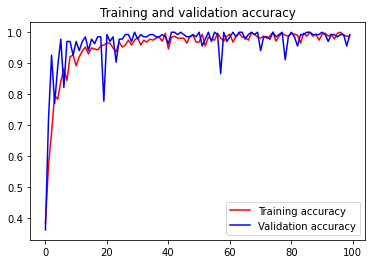

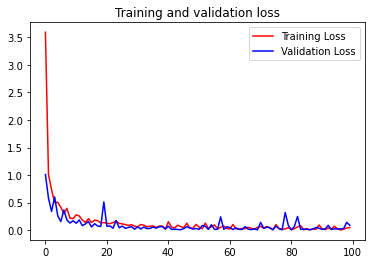

In [15]:
plot_training_validation_accuracy_loss(history)

**2. Measure: VGG19Model**

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(244,244),
                                                    subset='training',
                                                    seed=SEED)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT)

validation_generator = test_datagen.flow_from_directory(DATASET_PATH,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        target_size=(244,244),
                                                        subset='validation',
                                                        seed=SEED)

Found 315 images belonging to 3 classes.
Found 135 images belonging to 3 classes.


In [43]:
# Import the VGG-19 model  
from keras.applications.vgg19 import VGG19

vgg19_model = VGG19(input_shape = (244, 244, 3),
include_top = False, 
weights = 'imagenet')

In [44]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [45]:
vgg19_model.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

#### Hyperparamater

In [46]:
from tensorboard.plugins.hparams import api as hp
metric_accuracy = 'accuracy'
num_of_units = hp.HParam('num_units', hp.Discrete([32, 64, 256, 1024]))
#num_of_units_two = hp.HParam('num_units_two', hp.Discrete([32, 64, 256, 1024]))
#num_of_units_three = hp.HParam('num_units_three', hp.Discrete([32, 64, 256, 1024]))
dropout = hp.HParam('dropout', hp.RealInterval(0.2, 0.4))
#opti = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop']))

In [47]:
from keras import layers
from keras import Model

def create_and_train_model(hparams: dict, vgg19_model):
    last_layer = layers.Flatten()(vgg19_model.get_layer('block5_conv4').output)

    last_layer = layers.Dense(hparams[num_of_units], activation='relu')(last_layer)
    last_layer = layers.Dropout(hparams[dropout])(last_layer) 

    last_layer = layers.Dense(hparams[num_of_units], activation='relu')(last_layer)
    last_layer = layers.Dropout(hparams[dropout])(last_layer) 

    last_layer = layers.Dense(hparams[num_of_units], activation='relu')(last_layer)
    last_layer = layers.Dropout(hparams[dropout])(last_layer)     
     
    last_layer = layers.Dense(len(breeds), activation='softmax')(last_layer)
    
    model = Model(inputs=vgg19_model.input, outputs=last_layer)

    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    model.fit(train_generator, validation_data=(validation_generator), epochs=50)
    
    loss, accuracy = model.evaluate(validation_generator)
    
    return accuracy

In [48]:
# Set up for Tensorboardhyperparamtest
if os.path.exists('logs/param_test'):
  shutil.rmtree('logs/param_test')

with tf.summary.create_file_writer('logs/param_test').as_default():
    hp.hparams_config(
        #hparams=[num_of_units,num_of_units_two,num_of_units_three, dropout],
        hparams=[num_of_units, dropout],
        metrics=[hp.Metric(metric_accuracy, display_name='Accuracy')],)

def experiment(experiment_dir, hparams):
    with tf.summary.create_file_writer(experiment_dir).as_default():
        hp.hparams(hparams)
        accuracy = create_and_train_model(hparams, vgg19_model) # experiment run
        tf.summary.scalar(metric_accuracy, accuracy, step=1)

In [49]:
test_number = 0 # test counter
for num_units in num_of_units.domain.values: # try all four different values
    #for num_units_two in num_of_units_two.domain.values: # try all four different values
     #   for num_units_three in num_of_units_three.domain.values: # try all four different values
    for dropout_rate in (dropout.domain.min_value, dropout.domain.max_value): # try min and max value of dropout
        #for optimizer in opti.domain.values: # try all two different optimizers
        hparams = {
                num_of_units: num_units,
                  #  num_of_units_two: num_units_two,
                   # num_of_units_three: num_units_three,
                dropout: dropout_rate,
              #  opti: optimizer,
        }

        test_name = f'Test {test_number}'
        print(f'Starting Test: {test_name}')
        print({h.name: hparams[h] for h in hparams})
        experiment('logs/param_test/' + test_name, hparams)
        test_number += 1

Starting Test: Test 0
{'num_units': 32, 'dropout': 0.2, 'optimizer': 'rmsprop'}
Epoch 1/50


2022-06-27 15:09:08.767053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.0487 - accuracy: 0.3460

2022-06-27 15:09:25.276563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 22s 2s/step - loss: 5.0487 - accuracy: 0.3460 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/50
10/10 [==============================] - 19s 2s/step - loss: 1.0991 - accuracy: 0.3270 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 3/50
10/10 [==============================] - 19s 2s/step - loss: 1.0989 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 4/50
10/10 [==============================] - 19s 2s/step - loss: 1.1087 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 5/50
10/10 [==============================] - 20s 2s/step - loss: 1.0991 - accuracy: 0.3302 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 6/50
10/10 [==============================] - 19s 2s/step - loss: 1.0992 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 7/50
10/10 [==============================] - 19s 2s/step - loss: 1.0989 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 8/50
10/10 [=============

2022-06-27 15:25:35.071348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 4.0836 - accuracy: 0.4063

2022-06-27 15:25:50.934065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 21s 2s/step - loss: 4.0836 - accuracy: 0.4063 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/50
10/10 [==============================] - 20s 2s/step - loss: 1.8917 - accuracy: 0.3270 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 3/50
10/10 [==============================] - 19s 2s/step - loss: 1.2304 - accuracy: 0.3397 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 4/50
10/10 [==============================] - 19s 2s/step - loss: 1.0988 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 5/50
10/10 [==============================] - 19s 2s/step - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 6/50
10/10 [==============================] - 19s 2s/step - loss: 1.0989 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 7/50
10/10 [==============================] - 19s 2s/step - loss: 1.3414 - accuracy: 0.3460 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 8/50
10/10 [=============

2022-06-27 15:41:55.391986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 6.2329 - accuracy: 0.3429

2022-06-27 15:42:11.214270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 21s 2s/step - loss: 6.2329 - accuracy: 0.3429 - val_loss: 2.1263 - val_accuracy: 0.3333
Epoch 2/50
10/10 [==============================] - 20s 2s/step - loss: 1.6106 - accuracy: 0.3651 - val_loss: 1.0438 - val_accuracy: 0.6370
Epoch 3/50
10/10 [==============================] - 20s 2s/step - loss: 1.0917 - accuracy: 0.3619 - val_loss: 1.2029 - val_accuracy: 0.3333
Epoch 4/50
10/10 [==============================] - 20s 2s/step - loss: 1.1152 - accuracy: 0.3619 - val_loss: 1.0275 - val_accuracy: 0.4593
Epoch 5/50
10/10 [==============================] - 20s 2s/step - loss: 1.1085 - accuracy: 0.3492 - val_loss: 1.0671 - val_accuracy: 0.5259
Epoch 6/50
10/10 [==============================] - 20s 2s/step - loss: 1.1017 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 7/50
10/10 [==============================] - 20s 2s/step - loss: 1.0991 - accuracy: 0.2984 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 8/50
10/10 [=============

2022-06-27 15:58:22.293710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 8.0696 - accuracy: 0.3270

2022-06-27 15:58:38.190327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 21s 2s/step - loss: 8.0696 - accuracy: 0.3270 - val_loss: 1.2553 - val_accuracy: 0.3556
Epoch 2/50
10/10 [==============================] - 19s 2s/step - loss: 1.7356 - accuracy: 0.3238 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 3/50
10/10 [==============================] - 20s 2s/step - loss: 1.4825 - accuracy: 0.3302 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 4/50
10/10 [==============================] - 20s 2s/step - loss: 1.0995 - accuracy: 0.3302 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 5/50
10/10 [==============================] - 20s 2s/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 6/50
10/10 [==============================] - 20s 2s/step - loss: 1.0987 - accuracy: 0.3302 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 7/50
10/10 [==============================] - 20s 2s/step - loss: 1.1435 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 8/50
10/10 [=============

2022-06-27 16:15:02.426908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 14.8838 - accuracy: 0.3556

2022-06-27 16:15:18.470149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 21s 2s/step - loss: 14.8838 - accuracy: 0.3556 - val_loss: 1.9083 - val_accuracy: 0.5778
Epoch 2/50
10/10 [==============================] - 19s 2s/step - loss: 1.8612 - accuracy: 0.4063 - val_loss: 1.8093 - val_accuracy: 0.3333
Epoch 3/50
10/10 [==============================] - 20s 2s/step - loss: 1.2386 - accuracy: 0.4571 - val_loss: 0.9882 - val_accuracy: 0.4000
Epoch 4/50
10/10 [==============================] - 19s 2s/step - loss: 1.2436 - accuracy: 0.4000 - val_loss: 1.7539 - val_accuracy: 0.3333
Epoch 5/50
10/10 [==============================] - 19s 2s/step - loss: 1.1934 - accuracy: 0.3651 - val_loss: 1.1401 - val_accuracy: 0.3333
Epoch 6/50
10/10 [==============================] - 19s 2s/step - loss: 1.2923 - accuracy: 0.4222 - val_loss: 1.1437 - val_accuracy: 0.3333
Epoch 7/50
10/10 [==============================] - 19s 2s/step - loss: 1.1498 - accuracy: 0.4476 - val_loss: 0.9980 - val_accuracy: 0.5704
Epoch 8/50
10/10 [============

2022-06-27 16:31:24.136044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 16.0764 - accuracy: 0.2984

2022-06-27 16:31:40.117367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 21s 2s/step - loss: 16.0764 - accuracy: 0.2984 - val_loss: 1.4822 - val_accuracy: 0.3481
Epoch 2/50
10/10 [==============================] - 20s 2s/step - loss: 2.0843 - accuracy: 0.3429 - val_loss: 1.0648 - val_accuracy: 0.5481
Epoch 3/50
10/10 [==============================] - 19s 2s/step - loss: 1.2899 - accuracy: 0.4095 - val_loss: 1.2926 - val_accuracy: 0.3333
Epoch 4/50
10/10 [==============================] - 19s 2s/step - loss: 1.2546 - accuracy: 0.3238 - val_loss: 1.1125 - val_accuracy: 0.3333
Epoch 5/50
10/10 [==============================] - 19s 2s/step - loss: 1.2153 - accuracy: 0.3429 - val_loss: 1.0958 - val_accuracy: 0.3333
Epoch 6/50
10/10 [==============================] - 19s 2s/step - loss: 1.1450 - accuracy: 0.3524 - val_loss: 1.0814 - val_accuracy: 0.3333
Epoch 7/50
10/10 [==============================] - 20s 2s/step - loss: 1.3663 - accuracy: 0.3619 - val_loss: 1.5676 - val_accuracy: 0.3333
Epoch 8/50
10/10 [============

2022-06-27 16:47:52.071112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 64.8360 - accuracy: 0.3175

2022-06-27 16:48:08.662344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 22s 2s/step - loss: 64.8360 - accuracy: 0.3175 - val_loss: 2.3247 - val_accuracy: 0.3333
Epoch 2/50
10/10 [==============================] - 20s 2s/step - loss: 2.1458 - accuracy: 0.3778 - val_loss: 1.0265 - val_accuracy: 0.3778
Epoch 3/50
10/10 [==============================] - 20s 2s/step - loss: 1.5113 - accuracy: 0.3651 - val_loss: 1.4451 - val_accuracy: 0.3333
Epoch 4/50
10/10 [==============================] - 20s 2s/step - loss: 1.4312 - accuracy: 0.4667 - val_loss: 1.9435 - val_accuracy: 0.3333
Epoch 5/50
10/10 [==============================] - 20s 2s/step - loss: 1.4818 - accuracy: 0.4222 - val_loss: 1.3980 - val_accuracy: 0.3852
Epoch 6/50
10/10 [==============================] - 20s 2s/step - loss: 1.8118 - accuracy: 0.4603 - val_loss: 1.1938 - val_accuracy: 0.3704
Epoch 7/50
10/10 [==============================] - 20s 2s/step - loss: 1.0385 - accuracy: 0.5079 - val_loss: 1.5500 - val_accuracy: 0.3630
Epoch 8/50
10/10 [============

2022-06-27 17:04:43.031015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 67.5722 - accuracy: 0.3111

2022-06-27 17:04:59.479192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 22s 2s/step - loss: 67.5722 - accuracy: 0.3111 - val_loss: 1.1965 - val_accuracy: 0.3333
Epoch 2/50
10/10 [==============================] - 20s 2s/step - loss: 2.1716 - accuracy: 0.3683 - val_loss: 1.1358 - val_accuracy: 0.3333
Epoch 3/50
10/10 [==============================] - 20s 2s/step - loss: 1.4792 - accuracy: 0.3524 - val_loss: 1.0345 - val_accuracy: 0.3481
Epoch 4/50
10/10 [==============================] - 20s 2s/step - loss: 1.9137 - accuracy: 0.3587 - val_loss: 1.1184 - val_accuracy: 0.2889
Epoch 5/50
10/10 [==============================] - 20s 2s/step - loss: 1.1786 - accuracy: 0.2984 - val_loss: 1.0744 - val_accuracy: 0.3333
Epoch 6/50
10/10 [==============================] - 20s 2s/step - loss: 1.3185 - accuracy: 0.3492 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/50
10/10 [==============================] - 20s 2s/step - loss: 1.3647 - accuracy: 0.3238 - val_loss: 1.7737 - val_accuracy: 0.3333
Epoch 8/50
10/10 [============

In [51]:
%load_ext tensorboard
%tensorboard --logdir logs/param_test
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3762), started 3:07:21 ago. (Use '!kill 3762' to kill it.)

#### Result of hyperparamtest

number of units: 1024
dropout: 0.2
optimizer: rmsprop

#### Create final model

In [52]:
def create_final_model(vgg19_model):
    last_layer = layers.Flatten()(vgg19_model.get_layer('block5_conv4').output)
    last_layer = layers.Dense(1024, activation='relu')(last_layer)
    last_layer = layers.Dropout(0.2)(last_layer)
    last_layer = layers.Dense(1024, activation='relu')(last_layer)
    last_layer = layers.Dropout(0.2)(last_layer)
    last_layer = layers.Dense(1024, activation='relu')(last_layer)
    last_layer = layers.Dropout(0.2)(last_layer)
    last_layer = layers.Dense(len(breeds), activation='softmax')(last_layer)

    model = Model(inputs=vgg19_model.input, outputs=last_layer)

    model.compile(optimizer = 'rmsprop', 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model

In [53]:
model = create_final_model(vgg19_model)

In [54]:
# Tensorboard
tensorboard = keras.callbacks.TensorBoard(get_run_logdir("#3.Model"), 
                                             histogram_freq=1,)
history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            verbose=1, 
            callbacks=[tensorboard])
            

Epoch 1/100


2022-06-27 17:52:52.105187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 64.0682 - accuracy: 0.3365

2022-06-27 17:53:08.898515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 61s 6s/step - loss: 64.0682 - accuracy: 0.3365 - val_loss: 2.2797 - val_accuracy: 0.5778
Epoch 2/100
10/10 [==============================] - 57s 6s/step - loss: 2.5666 - accuracy: 0.4063 - val_loss: 1.4730 - val_accuracy: 0.5259
Epoch 3/100
10/10 [==============================] - 57s 6s/step - loss: 2.6775 - accuracy: 0.3746 - val_loss: 2.2624 - val_accuracy: 0.5556
Epoch 4/100
10/10 [==============================] - 58s 6s/step - loss: 1.8884 - accuracy: 0.5238 - val_loss: 1.2924 - val_accuracy: 0.3926
Epoch 5/100
10/10 [==============================] - 58s 6s/step - loss: 1.4295 - accuracy: 0.4635 - val_loss: 1.8847 - val_accuracy: 0.4222
Epoch 6/100
10/10 [==============================] - 58s 6s/step - loss: 2.3482 - accuracy: 0.4508 - val_loss: 1.0398 - val_accuracy: 0.6148
Epoch 7/100
10/10 [==============================] - 58s 6s/step - loss: 1.0724 - accuracy: 0.5524 - val_loss: 0.9108 - val_accuracy: 0.6000
Epoch 8/100
10/10 [=====

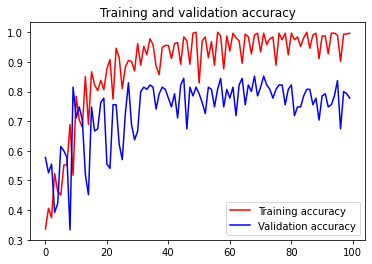

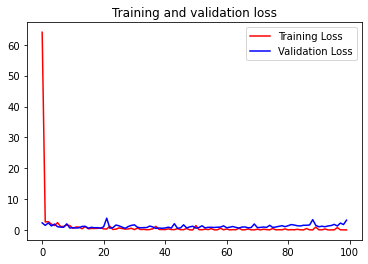

In [55]:
plot_training_validation_accuracy_loss(history)

### Tensorboard

In [57]:
%load_ext tensorboard
%tensorboard --logdir=./logs
%reload_ext tensorboard 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 7799), started 0:00:04 ago. (Use '!kill 7799' to kill it.)